<a href="https://www.kaggle.com/code/nidropakshin/sir-flow?scriptVersionId=297908767" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Введение 

В этом блокноте мы опробуем метод Flow Matching Posterior Estimation на модели SIR (Susceptible-Infectious-Recovered) - игрушечная модель распространения эпидемий

In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from torch import nn, Tensor
import time
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
if not os.path.exists("./models"):
    os.mkdir("./models")

Зададим распределение из которого будем сэмплировать параметры для модели и начальное распредение для обучаемого потока

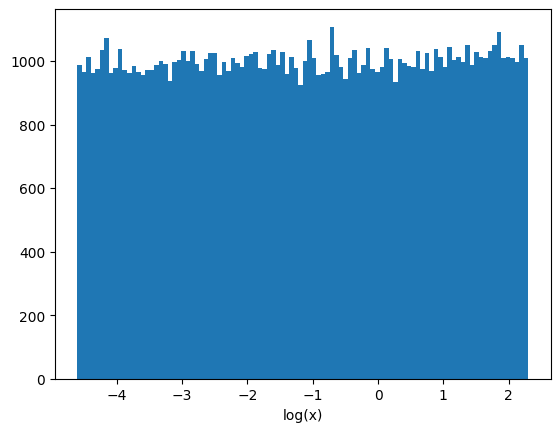

In [2]:
def sample_log_uniform(low, high, size, device=None):
    """
    low, high: scalars (floats), low > 0
    size: tuple, e.g. (B,)
    """
    u = torch.rand(size, device=device)
    log_low = torch.log(torch.tensor(low, device=device))
    log_high = torch.log(torch.tensor(high, device=device))
    return torch.exp(log_low + u * (log_high - log_low)).to(device)


def sample_prior(B, device=None):
    gamma = sample_log_uniform(0.05, 0.5, (B, 1), device)
    R0 = sample_log_uniform(0.5, 5.0, (B, 1), device)
    beta = R0 * gamma
    return torch.cat([beta, gamma], dim=1).to(device)


def sample_init_dist(B, device=None):
    return torch.rand(size=(B, 2)).to(device)


samples = sample_log_uniform(0.01, 10.0, (100_000,))
plt.hist(torch.log(samples).numpy(), bins=100)
plt.xlabel("log(x)")
plt.show()

Модель устроена следующим образом. В каждый момент времени состояние описывается тремя числами $S, I, R$ - которые означают число людей из соответстующей категории ($S$ - Здоровые, $I$ - Больные, $R$ - Переболевшие). Всегда выполнено соотношение $S + I + R = N$ - общее число людей, а динамика задается так

$$
S_{t+1} = S_t - \Delta_{inf}
$$
$$
I_{t+1} = I_t + \Delta_{inf} - \Delta_{rec}
$$
$$
R_{t+1} = R_t + \Delta_{rec}
$$

где $\Delta_{inf} \sim Binomial(S, 1 - e^{-\beta \frac{I}{N}}), \Delta_{rec} \sim Binomial(I, 1 - e^{-\gamma})$

tensor([[0.3309, 0.0723],
        [0.4964, 0.1085]])


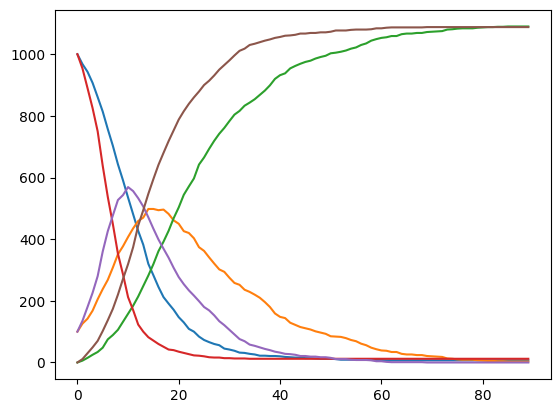

In [3]:
def simulate(phi, sir=(1000, 100, 0), T=90):
    S, I, R = sir
    S = torch.zeros(phi.shape[0], device=phi.device) + S
    I = torch.zeros(phi.shape[0], device=phi.device) + I
    R = torch.zeros(phi.shape[0], device=phi.device) + R
    N = S + I + R
    states = torch.zeros(phi.shape[0], T, 3, device=phi.device)
    for t in range(0, T):
        states[:, t, 0] = S
        states[:, t, 1] = I
        states[:, t, 2] = R

        p_inf = 1 - torch.exp(-phi[:, 0] * I / N)
        p_rec = 1 - torch.exp(-phi[:, 1])

        new_inf = torch.binomial(S, p_inf)
        new_rec = torch.binomial(I, p_rec)

        S = S - new_inf
        I = I + new_inf - new_rec
        R = R + new_rec

    states[:, T-1, 0] = S
    states[:, T-1, 1] = I
    states[:, T-1, 2] = R
    return states        
    
sir = (1000, 100, 0)
phi = sample_prior(2)
phi[1, :] = 1.5*phi[0, :] 
print(phi)
x_0, x_1 = simulate(phi, sir, 90).cpu()
S, I, R = x_0[:, 0], x_0[:, 1], x_0[:, 2]
plt.plot(S)
plt.plot(I)
plt.plot(R)
S, I, R = x_1[:, 0], x_1[:, 1], x_1[:, 2]
plt.plot(S)
plt.plot(I)
plt.plot(R)

Итого, данные, которые мы получаем - это временной ряд $x_{1:T} \in \mathbb{N}^3$ - обрабатывать это все разом не хочется, поэтому сделаем из них выжимку. Для начала можно самим придумать критерии, которые хорошо характеризуют симуляцию:

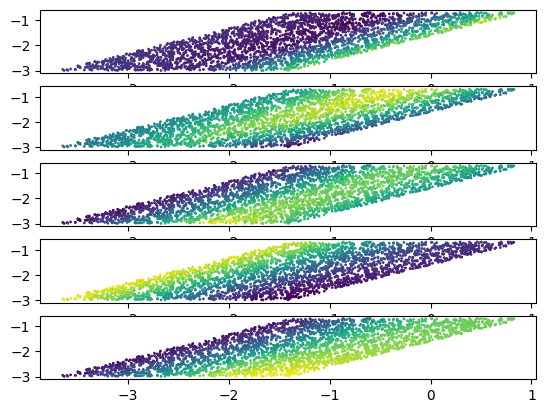

In [4]:
def safe_div(a, b, eps=1e-8):
    return a / (b + eps)

def handmade_summary(x, eps=1e-8):
    S = x[:, :, 0]
    I = x[:, :, 1]
    R = x[:, :, 2]
    batch, T = I.shape

    N = S[:, 0] + I[:, 0] + R[:, 0]
    N = N.clamp(min=eps)

    
    I_peak, t_peak = I.max(dim=1)            
    t_peak = t_peak.to(torch.float32) / float(max(1, T - 1))
    t_peak = t_peak.unsqueeze(1)             

    I_peak_frac = safe_div(I_peak, N).unsqueeze(1)
    
    I_mean_frac = safe_div(I.mean(dim=1), N).unsqueeze(1)

    R_final_frac = safe_div(R[:, -1], N).unsqueeze(1)

    S_final_frac = safe_div(S[:, -1], N).unsqueeze(1)

    
    s = torch.cat([t_peak, I_peak_frac, I_mean_frac, R_final_frac, S_final_frac], dim=1).to(x.device)
    
    B = torch.tensor([[-0.6543, -1.0543,  0.4823, -0.4612,  0.7340],
                      [ 2.6280, -1.6988, -0.6246, -0.0949, -0.3497],
                      [ 0.4116, -0.8507, -0.1116, -0.5067,  1.4959],
                      [-0.2124, -0.1211, -0.8651, -1.2937,  1.2938],
                      [ 0.0257, -0.9242, -1.4133,  0.3826, -1.0719]]).to(x.device)
    
    s = torch.matmul(s, B)
    
    return s

def visualize_summary_features(summary):
    phi = sample_prior(3000)
    x = simulate(phi, (1000, 500, 0), 90)
    s = summary(x)
    _, ax = plt.subplots(s.shape[1], 1, sharey=True)
    for i in range(s.shape[1]):
        ax[i].scatter(torch.log(phi[:, 0]), torch.log(phi[:, 1]), c=s[:, i], s=1)
        # ax[i].scatter(phi[:, 0], phi[:, 1], c=s[:, i], s=1)

visualize_summary_features(handmade_summary)

Теперь опишем класс нашего потока. Здесь пока что используется самый простой Conditional Flow, где в качестве условия стоит выжимка из данных

In [5]:
class CondFlow(nn.Module):
    def __init__(self, phi_dim, x_dim, h):
        super().__init__()
        self.dim = phi_dim
        self.net = nn.Sequential(
            nn.Linear(1 + x_dim + phi_dim, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, phi_dim)
        )
    
    def forward(self, t, x, phi):
        return self.net(torch.cat((t, x, phi), dim=-1))
    
    def step(self, phi, x, t_start, t_end):
        t_start = t_start.view(1, 1).expand(phi.shape[0], 1)
        t_end = t_end.view(1, 1).expand(phi.shape[0], 1)
        
        t_mid = (t_end + t_start) / 2
        phi_mid = phi + self.forward(t=t_start, x=x, phi=phi) * (t_mid - t_start)
        return  phi + self.forward(t=t_mid, x=x, phi=phi_mid) * (t_end - t_start)

model = CondFlow(2, 5, 16)
beta, gamma = 0.5, 0.5
sir = (1000, 100, 0)

phi = torch.tensor([[beta, gamma]])
x = simulate(phi, sir, 90)
s = handmade_summary(x)
t = torch.tensor([[0.0]])
model(t=t, x=s, phi=phi)

tensor([[ 0.1048, -0.1051]], grad_fn=<AddmmBackward0>)

В качестве начального распределения лучше всего себя показывает равномерное, а условный поток мы возьмем линейным 
$$\phi_t = (1 - t) \cdot \phi_0 + t \cdot \phi_1$$

Epoch: 0, Loss: 0.1955
Epoch: 500, Loss: 0.0470
Epoch: 1000, Loss: 0.0330
Epoch: 1500, Loss: 0.0268
Epoch: 2000, Loss: 0.0226
Epoch: 2500, Loss: 0.0205
Epoch: 3000, Loss: 0.0192
Epoch: 3500, Loss: 0.0186
Epoch: 4000, Loss: 0.0183
Epoch: 4500, Loss: 0.0165
Epoch: 5000, Loss: 0.0176


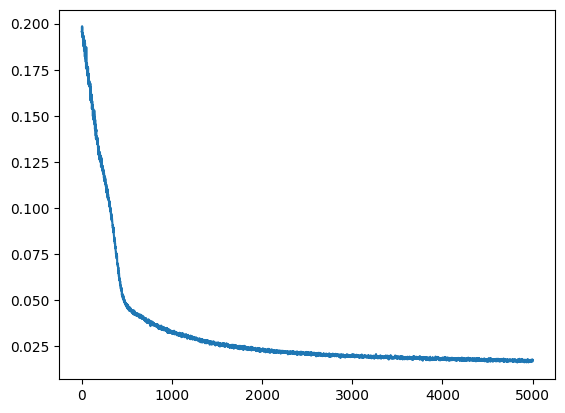

In [6]:
def train(model, 
          summary,
          sim_parameters,
          optimizer, 
          loss_fn, 
          epochs=2000,
          path="./models",
          show_every=None, 
          show_loss=False):
    
    model.train()
    sir = sim_parameters["sir"]
    T_max = sim_parameters["T_max"]

    losses = []
    min_loss = torch.inf

    if not show_every is None:
        show_loss = True

    
    for i in range(epochs+1):
        phi_1 = sample_prior(10000).to(device)
        x = simulate(phi_1, sir, T_max).to(device)
        s = summary(x).to(device)
        
        phi_0 = sample_init_dist(phi_1.shape[0]).to(device)
        t = torch.rand(phi_1.shape[0], 1).to(device)

        phi_t = (1 - t) * phi_0 + t * phi_1
        dphi_t = phi_1 - phi_0

        v = model(t=t, x=s, phi=phi_t)
        loss = loss_fn(v, dphi_t)
        losses.append(loss.detach().item())

        if loss < min_loss:
            torch.save(model.state_dict(), path)
        
        if show_loss and i % show_every == 0:
            print(f"Epoch: {i}, Loss: {losses[i]:.4f}")#, Time: {(time.time() - s):.2f}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses

def pipeline(model,
             summary,
             optimizer,
             sim_parameters,
             train_model=True,
             epochs=2000, 
             show_every=200,
             device=torch.device(device)):
    if train_model:
        model.train()
        
        loss = torch.nn.MSELoss()
        
        datetime = time.strftime("%Y-%m-%d_%H_%M_%S")
        path = f"./models/SIR_{datetime}.pth.tar.gz" 
    
        losses = train(model, 
                       summary, 
                       sim_parameters, 
                       optimizer, 
                       loss, 
                       path=path, 
                       epochs=epochs, 
                       show_every=show_every)
        plt.plot(losses)
        return losses
    
    else:
        assert os.path.exists(path)
        model.load_state_dict(torch.load(path, weights_only=True, map_location=torch.device(device)))
        model.eval()


simple_model = CondFlow(2, 5, 64).to(device)
optimizer = torch.optim.Adam(simple_model.parameters(), lr=1e-4)
sim_parameters = {"sir": (1000, 100, 0),
                  "T_max": 90}

losses = pipeline(simple_model,
                  handmade_summary,
                  optimizer,
                  sim_parameters,
                  train_model=True,
                  epochs=5000, 
                  show_every=500)

Посмотрим что получилось

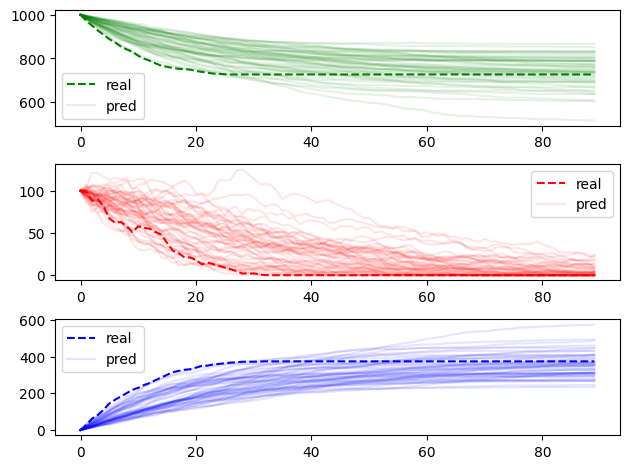

In [7]:
def sample_posterior(model, x, 
                     n_steps=10, 
                     n_samples=1000, 
                     plot=False, 
                     log_scale=False):
    model.eval()
    posterior = []
    time_steps = torch.linspace(0.0, 1.0, n_steps + 1).to(device)
    
    for i in range(n_samples):
        # pred_phi = torch.randn(size=(x.shape[0], 2)).to(device)
        pred_phi = sample_init_dist(x.shape[0]).to(device)
        for i in range(n_steps):
            pred_phi = model.step(phi=pred_phi, x=x, t_start=time_steps[i], t_end=time_steps[i+1])
        posterior.append(pred_phi[:, None, :])

    posterior = torch.cat(posterior, dim=1).detach()
    
    if plot:
        mean = posterior.mean(dim=1)
        std = (posterior - mean[:, None, :]).pow(2).mean(dim=1).pow(0.5)
            
        if phi.shape[0] == 1:
            _, ax = plt.subplots(1, 1, figsize=(4, 4))
            if log_scale:
                ax.scatter(torch.log(posterior[0, :, 0]).cpu(), torch.log(posterior[0, :, 1]).cpu(), s=1, label="Posterior")
                ax.scatter(torch.log(phi[0, 0]).cpu(), torch.log(phi[0, 1]).cpu(), s=10, label="True phi")
                ax.scatter(torch.log(mean[0, 0]).cpu(), torch.log(mean[0, 1]).cpu(), s=10, label="Mean", color="red")
            else:
                ax.scatter(posterior[0, :, 0].cpu(), posterior[0, :, 1].cpu(), s=1, label="Posterior")
                ax.scatter(phi[0, 0].cpu(), phi[0, 1].cpu(), s=10, label="True phi")
                ax.scatter(mean[0, 0].cpu(), mean[0, 1].cpu(), s=10, label="Mean", color="red")
            ax.legend()
        
        else:
            _, ax = plt.subplots(max(phi.shape[0], 2), 1, figsize=(4, 4 * (max(phi.shape[0], 2))))
    
            for i in range(x.shape[0]):
                if log_scale:
                    ax[i].scatter(torch.log(posterior[i, :, 0]).cpu(), torch.log(posterior[i, :, 1]).cpu(), s=1, label="Posterior")
                    ax[i].scatter(torch.log(phi[i, 0]).cpu(), torch.log(phi[i, 1]).cpu(), s=10, label="True phi")
                    ax[i].scatter(torch.log(mean[i, 0]).cpu(), torch.log(mean[i, 1]).cpu(), s=10, label="Mean", color="red")
                else:
                    ax[i].scatter(posterior[i, :, 0].cpu(), posterior[i, :, 1].cpu(), s=1, label="Posterior")
                    ax[i].scatter(phi[i, 0].cpu(), phi[i, 1].cpu(), s=10, label="True phi")
                    ax[i].scatter(mean[i, 0].cpu(), mean[i, 1].cpu(), s=10, label="Mean", color="red")
                ax[i].legend()
    return posterior



phi = sample_prior(1).to(device)
x = simulate(phi)
s = handmade_summary(x).to(device)

phi_pred = sample_posterior(simple_model, s, n_samples=50)

x_real = simulate(phi).detach().cpu()
x_pred = simulate(phi_pred[0]).detach().cpu()

S_real, I_real, R_real = x_real[0, :, 0], x_real[0, :, 1], x_real[0, :, 2]

_, ax = plt.subplots(3, 1)
ax[0].plot(S_real, linestyle="--", color="green", label="real")
ax[1].plot(I_real, linestyle="--", color="red", label="real")
ax[2].plot(R_real, linestyle="--", color="blue", label="real")

for i in range(x_pred.shape[0]):
    S_pred, I_pred, R_pred = x_pred[i, :, 0], x_pred[i, :, 1], x_pred[i, :, 2]

    ax[0].plot(S_pred, color="green", label="pred", alpha=0.1)
    ax[1].plot(I_pred, color="red",   label="pred", alpha=0.1)
    ax[2].plot(R_pred, color="blue",  label="pred", alpha=0.1)
    if i == 0:
        [ax[j].legend() for j in range(3)]
plt.tight_layout()

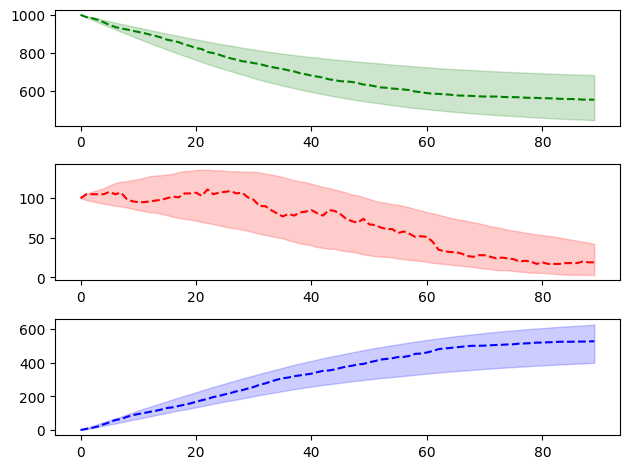

In [8]:
def visualize_pred_simulation(model, summary): 

    phi = sample_prior(1).to(device)
    x = simulate(phi)
    s = summary(x).to(device)
    
    phi_pred = sample_posterior(model, s, n_samples=100)
    
    x_real = simulate(phi).detach().cpu()
    x_pred = simulate(phi_pred[0]).detach().cpu()
    
    
    S_real, I_real, R_real = x_real[0, :, 0], x_real[0, :, 1], x_real[0, :, 2]
    S_pred, I_pred, R_pred = x_pred[:, :, 0], x_pred[:, :, 1], x_pred[:, :, 2]
    
    
    _, ax = plt.subplots(3, 1)
    ax[0].plot(S_real, linestyle="--", color="green", label="real")
    ax[1].plot(I_real, linestyle="--", color="red", label="real")
    ax[2].plot(R_real, linestyle="--", color="blue", label="real")
    
    S_mean, I_mean, R_mean = S_pred.mean(dim=0), I_pred.mean(dim=0), R_pred.mean(dim=0)
    S_std, I_std, R_std = S_pred.std(dim=0), I_pred.std(dim=0), R_pred.std(dim=0)
    
    ax[0].fill_between(torch.arange(0, 90), S_mean - S_std, S_mean + S_std, color="green", label="pred", alpha=0.2)
    ax[1].fill_between(torch.arange(0, 90), I_mean - I_std, I_mean + I_std, color="red", label="pred", alpha=0.2)
    ax[2].fill_between(torch.arange(0, 90), R_mean - R_std, R_mean + R_std, color="blue", label="pred", alpha=0.2)
    
    plt.tight_layout()

visualize_pred_simulation(simple_model, handmade_summary)

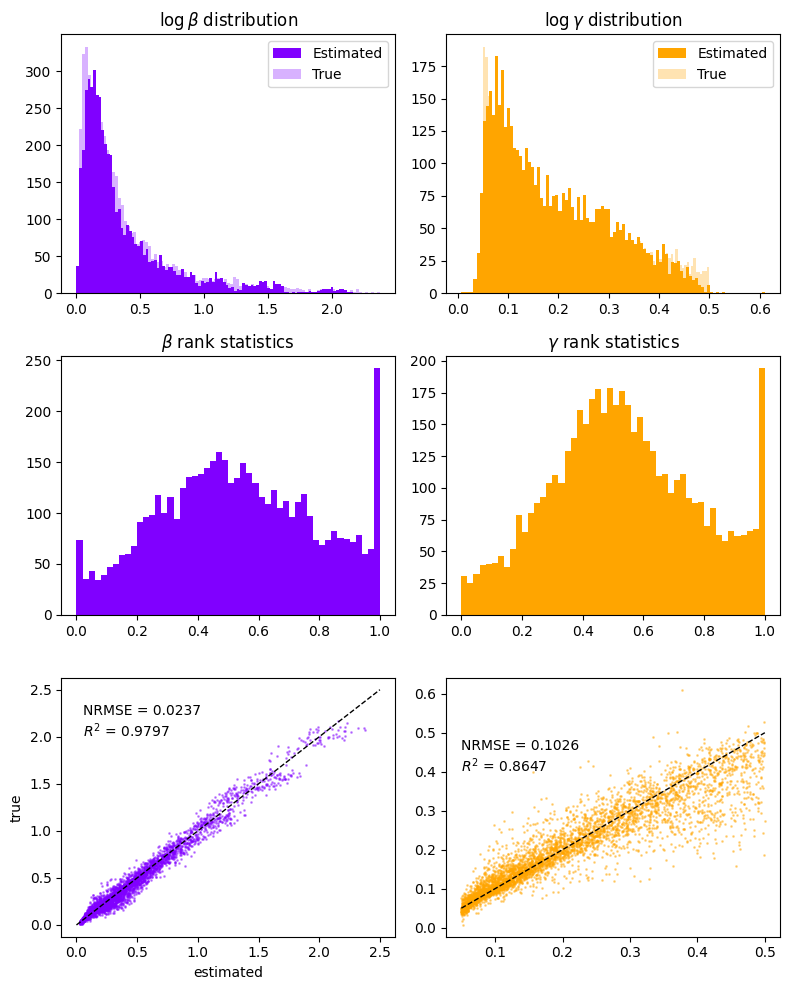

In [9]:
def nrmse(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    rmse = torch.sqrt(mse)
    norm_factor = torch.max(y_true) - torch.min(y_true)
    nrmse_value = rmse / norm_factor
    return nrmse_value


def r2_score(y_true, y_pred):
    mean_y_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_y_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2


def metrics(model, summary):
    phi = sample_prior(5000).to(device)

    x = simulate(phi)
    s = summary(x).to(device)
    
    posterior = sample_posterior(model, s, n_steps=10, n_samples=50)
    phi_pred = posterior.mean(dim=1)
    ranks = (posterior < phi[:, None, :]).sum(dim=-2) / posterior.shape[1]
    
    _, ax = plt.subplots(3, 2, figsize=(8, 10))

    ax[0][0].hist(phi_pred[:, 0].cpu(), bins=100, color="#8000ff", label="Estimated")
    ax[0][0].hist(phi[:, 0].cpu(), bins=100, color="#8000ff", alpha=0.3, label="True")
    ax[0][0].set_title(r"$\log \beta$ distribution")
    ax[0][0].legend()
    
    ax[0][1].hist(phi_pred[:, 1].cpu(), bins=100, color="orange", label="Estimated")
    ax[0][1].hist(phi[:, 1].cpu(), bins=100, color="orange", alpha=0.3, label="True")
    ax[0][1].set_title(r"$\log \gamma$ distribution")
    ax[0][1].legend()
    
    ax[1][0].hist(ranks[:, 0].cpu(), bins=50, color="#8000ff")
    ax[1][0].set_title(r"$\beta$ rank statistics")
    ax[1][1].hist(ranks[:, 1].cpu(), bins=50, color="orange")
    ax[1][1].set_title(r"$\gamma$ rank statistics")
    
    # ax[1][0].scatter(torch.log(phi[:, 0]).cpu(), torch.log(phi[:, 1]).cpu(), s=1, label="True prior")
    # ax[1][0].scatter(torch.log(posterior[:, 0]).cpu(), torch.log(posterior[:, 1]).cpu(), s=1, label="Estimated prior")
    # ax[1][0].set_title("dists in log scale")
    # ax[1][0].legend()
    
    # ax[1][1].scatter(phi[:, 0].cpu(), phi[:, 1].cpu(), s=1, label="True prior")
    # ax[1][1].scatter(posterior[:, 0].cpu(), posterior[:, 1].cpu(), s=1, label="Estimated prior")
    # ax[1][1].set_title("dists in normal scale")
    # ax[1][1].legend()

    ax[2][0].plot([0, 2.5], [0, 2.5], linestyle="--", color="black", linewidth=1)
    ax[2][0].scatter(phi[:, 0].cpu(), phi_pred[:, 0].cpu(), s=1, alpha=0.4, color="#8000ff")
    ax[2][0].set_xlabel("estimated")
    ax[2][0].set_ylabel("true")
    ax[2][0].text(s=f"NRMSE = {nrmse(phi[:, 0], phi_pred[:, 0]):.4f}\n" + \
                    f"$R^2$ = {r2_score(phi[:, 0], phi_pred[:, 0]):.4f}",
                 x=0.05, y=2.0)
    
    ax[2][1].plot([0.05, 0.5], [0.05, 0.5], linestyle="--", color="black", linewidth=1)
    ax[2][1].scatter(phi[:, 1].cpu(), phi_pred[:, 1].cpu(), s=1, alpha=0.4, color="orange")
    ax[2][1].text(s=f"NRMSE = {nrmse(phi[:, 1], phi_pred[:, 1]):.4f}\n" + \
                    f"$R^2$ = {r2_score(phi[:, 1], phi_pred[:, 1]):.4f}",
                 x=0.05, y=0.4)
    
    plt.tight_layout()

metrics(simple_model, handmade_summary)

Ранговые статистики и метрики $NRMSE$ и $R^2$ $-$ стандартый набор для калибровки SBI моделей  

Посмотрим как модель ведет себя локально 

True: tensor([0.8406, 0.4544], device='cuda:0'), Mean: tensor([0.9504, 0.4827]), STD: tensor([0.0655, 0.0347])
True: tensor([0.6141, 0.4834], device='cuda:0'), Mean: tensor([0.4627, 0.3626]), STD: tensor([0.0847, 0.0707])


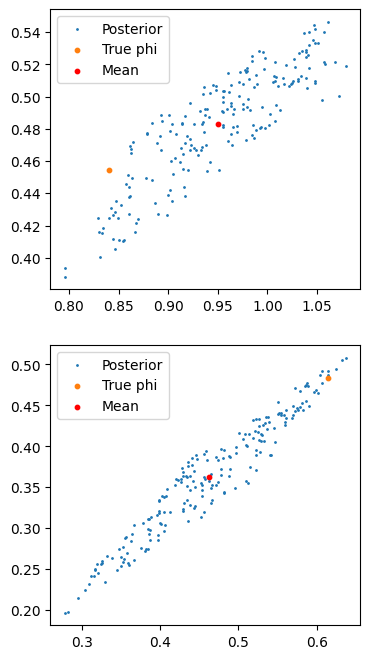

In [10]:
# phi = sample_prior(2)
phi = torch.tensor([[0.8406, 0.4544],
                    [0.6141, 0.4834]]).to(device)
x = simulate(phi)
s = handmade_summary(x).to(device)

posterior = sample_posterior(simple_model, s, n_steps=10, n_samples=200, plot=True).cpu()
mean = posterior.mean(dim=1)
std = (posterior - mean[:, None, :]).pow(2).mean(dim=1).pow(0.5)
for i in range(mean.shape[0]):
    print(f"True: {phi[i]}, Mean: {mean[i]}, STD: {std[i]}")

Результаты вроде неплохие, но можно ли их улучшить? Например, взять саммари получше. Дальше просто эксперименты с разными обучаемыми саммари сетями: RNN, MLP, CNN

In [11]:
class RNNSummary(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=128, n_layers=1, emb_dim=64):
        super().__init__()
        self.rnn = torch.nn.RNN(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, emb_dim),
            torch.nn.ReLU(),
        )
    def forward(self, x):
        # x: (B, T, F)
        _, h = self.rnn(x)    # h: (num_layers, B, out_dim)
        s = self.fc(h)[-1, :] # (B, emb_dim)
        return s

phi = sample_prior(1000)
x = simulate(phi, sir, 90)
rnn_summary = RNNSummary(3, 16, 4, 5)
rnn_summary(x).shape

torch.Size([1000, 5])

Epoch: 0, Loss: 0.2644
Epoch: 500, Loss: 0.1061
Epoch: 1000, Loss: 0.0888
Epoch: 1500, Loss: 0.0839
Epoch: 2000, Loss: 0.0786
Epoch: 2500, Loss: 0.0712
Epoch: 3000, Loss: 0.0673
Epoch: 3500, Loss: 0.0628
Epoch: 4000, Loss: 0.0649
Epoch: 4500, Loss: 0.0635
Epoch: 5000, Loss: 0.0619


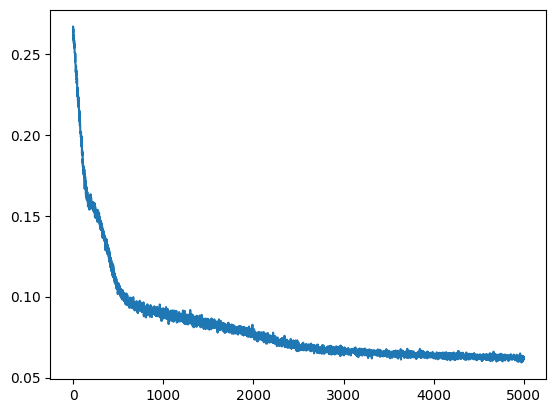

In [12]:
rnn_model = CondFlow(2, 5, 64).to(device)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-4)
sim_parameters = {"sir": (1000, 100, 0),
                  "T_max": 90}
rnn_summary.to(device)

losses = pipeline(rnn_model,
                  rnn_summary,
                  optimizer,
                  sim_parameters,
                  train_model=True,
                  epochs=5000, 
                  show_every=500)

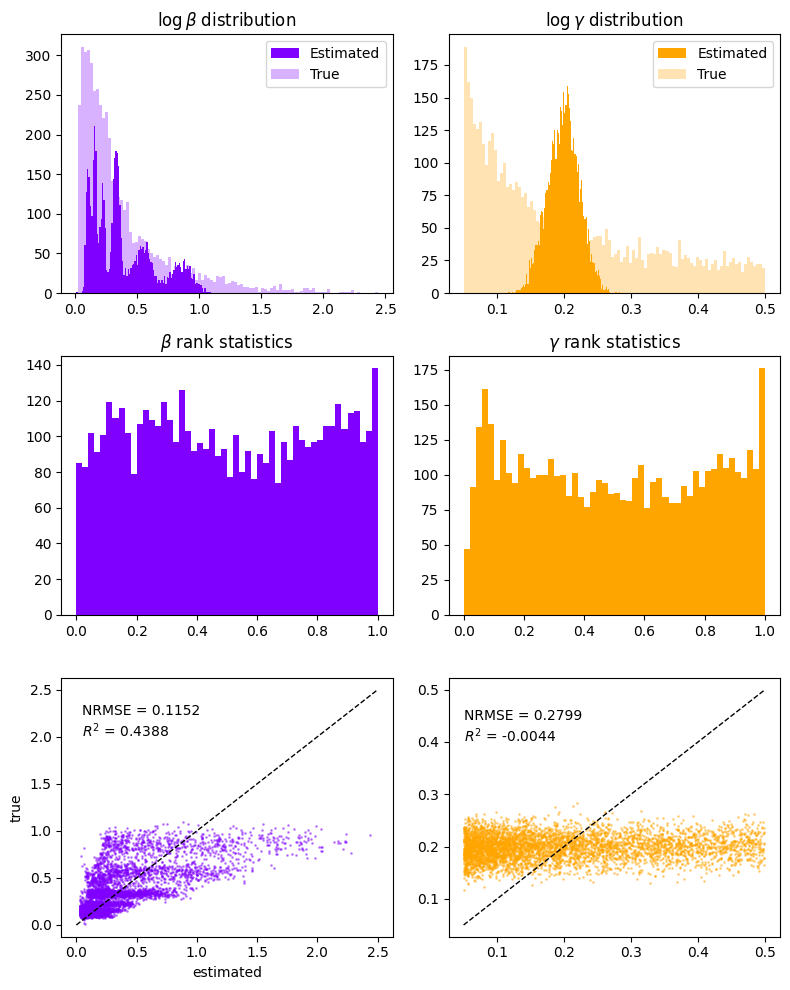

In [13]:
metrics(rnn_model, rnn_summary)

True: tensor([0.4409, 0.3142], device='cuda:0'), Mean: tensor([0.3632, 0.2151]), STD: tensor([0.2055, 0.1287])
True: tensor([0.6444, 0.3282], device='cuda:0'), Mean: tensor([0.3129, 0.1878]), STD: tensor([0.1781, 0.1180])


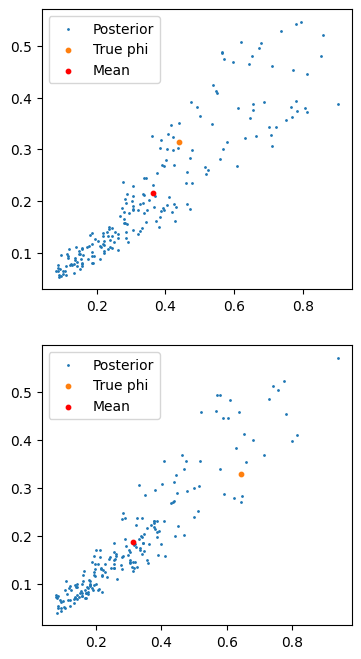

In [14]:
phi = sample_prior(2).to(device)
x = simulate(phi)
s = rnn_summary(x).to(device)

posterior = sample_posterior(rnn_model, s, n_steps=32, n_samples=200, plot=True).cpu()
mean = posterior.mean(dim=1)
std = (posterior - mean[:, None, :]).pow(2).mean(dim=1).pow(0.5)
for i in range(mean.shape[0]):
    print(f"True: {phi[i]}, Mean: {mean[i]}, STD: {std[i]}")

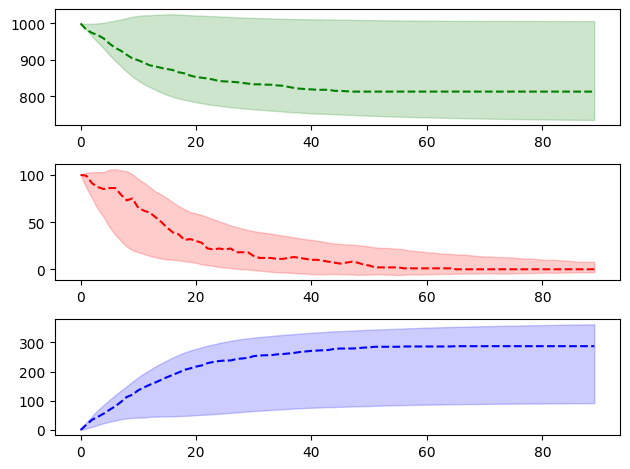

In [15]:
visualize_pred_simulation(rnn_model, rnn_summary)

In [16]:
class MLPSummary(torch.nn.Module):
    def __init__(self, num_channels, hidden_dim=128, n_layers=1, emb_dim=64):
        super().__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(90, hidden_dim), torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, emb_dim)
        )
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(3, 16), torch.nn.ReLU(),
            torch.nn.Linear(16, 1)
        )
    def forward(self, x):
        x = x.permute(0, 2, 1)
        s = self.fc1(x).permute(0, 2, 1)
        s = self.fc2(s).permute(0, 2, 1)[:, 0] # (B, emb_dim)
        return s

phi = sample_prior(1000)
x = simulate(phi, sir, 90)
mlp_summary = MLPSummary(3, 16, 4, 32)
mlp_summary(x).shape

torch.Size([1000, 32])

Epoch: 0, Loss: 0.2699
Epoch: 500, Loss: 0.0548
Epoch: 1000, Loss: 0.0235
Epoch: 1500, Loss: 0.0184
Epoch: 2000, Loss: 0.0143
Epoch: 2500, Loss: 0.0118
Epoch: 3000, Loss: 0.0109
Epoch: 3500, Loss: 0.0106
Epoch: 4000, Loss: 0.0101
Epoch: 4500, Loss: 0.0099
Epoch: 5000, Loss: 0.0099


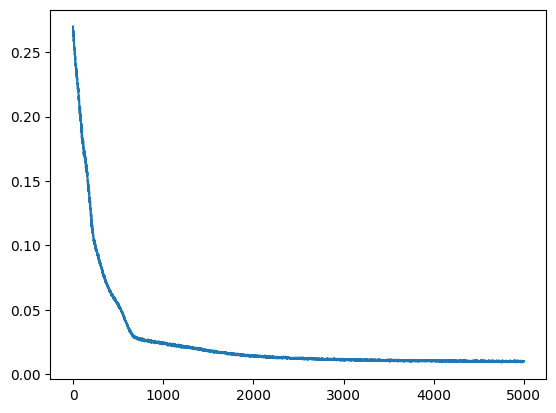

In [17]:
mlp_model = CondFlow(2, 32, 64).to(device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-4)
sim_parameters = {"sir": (1000, 100, 0),
                  "T_max": 90}
mlp_summary.to(device)

losses = pipeline(mlp_model,
                  mlp_summary,
                  optimizer,
                  sim_parameters,
                  train_model=True,
                  epochs=5000, 
                  show_every=500)

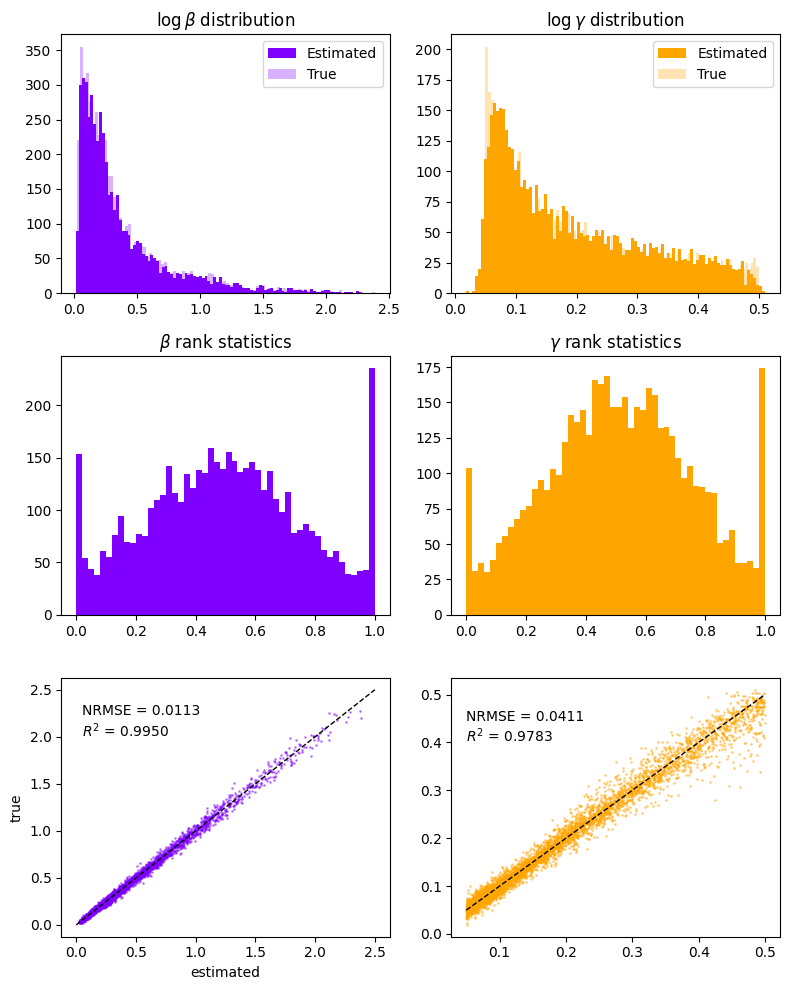

In [18]:
metrics(mlp_model, mlp_summary)

True: tensor([0.0763, 0.0754], device='cuda:0'), Mean: tensor([0.0825, 0.0797]), STD: tensor([0.0149, 0.0140])
True: tensor([0.2605, 0.2625], device='cuda:0'), Mean: tensor([0.2639, 0.2552]), STD: tensor([0.0223, 0.0221])


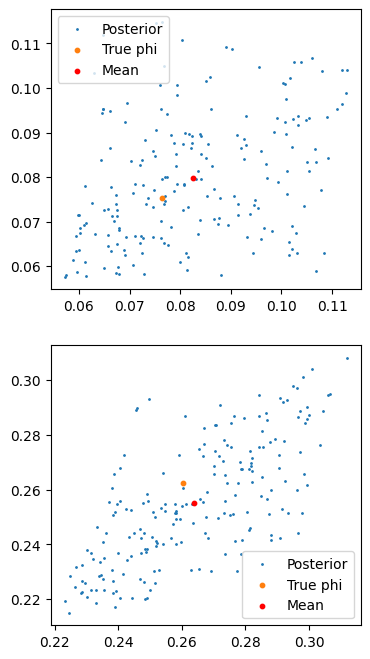

In [19]:
phi = sample_prior(2).to(device)
x = simulate(phi)
s = mlp_summary(x).to(device)

posterior = sample_posterior(mlp_model, s, n_steps=32, n_samples=200, plot=True).cpu()
mean = posterior.mean(dim=1)
std = (posterior - mean[:, None, :]).pow(2).mean(dim=1).pow(0.5)
for i in range(mean.shape[0]):
    print(f"True: {phi[i]}, Mean: {mean[i]}, STD: {std[i]}")

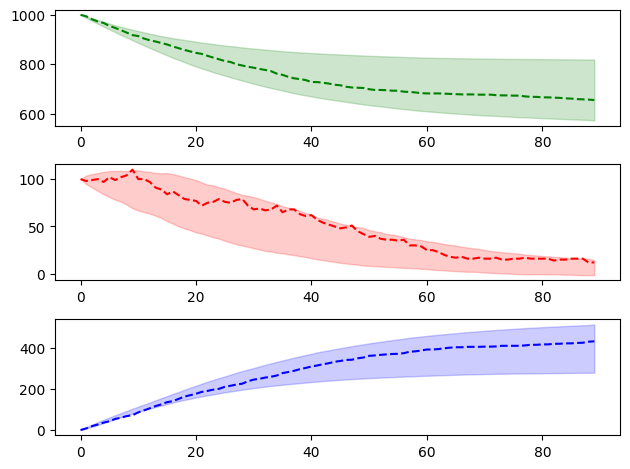

In [20]:
visualize_pred_simulation(mlp_model, mlp_summary)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class CNNSummary(nn.Module):
    def __init__(self, input_channels=3, sequence_length=90, hidden_dim=64, output_dim=1):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.AdaptiveAvgPool1d(1)
        
        self.fc1 = nn.Linear(64, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))   
        
        x = x.squeeze(-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


phi = sample_prior(1000)
x = simulate(phi, sir, 90)
cnn_summary = CNNSummary(3, 90, 16, 5)
cnn_summary(x).shape

torch.Size([1000, 5])

Epoch: 0, Loss: 0.2087
Epoch: 500, Loss: 0.0837
Epoch: 1000, Loss: 0.0612
Epoch: 1500, Loss: 0.0399
Epoch: 2000, Loss: 0.0278
Epoch: 2500, Loss: 0.0246
Epoch: 3000, Loss: 0.0236
Epoch: 3500, Loss: 0.0225
Epoch: 4000, Loss: 0.0206
Epoch: 4500, Loss: 0.0191
Epoch: 5000, Loss: 0.0186


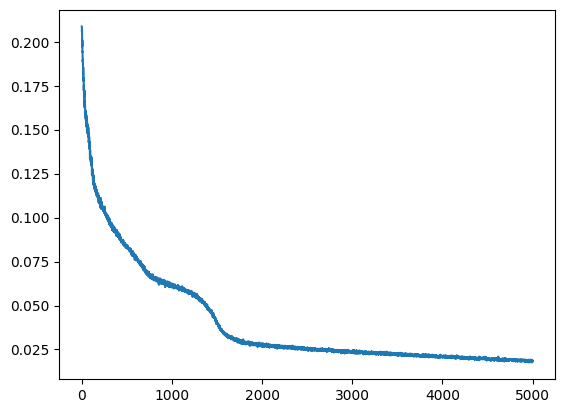

In [22]:
cnn_model = CondFlow(2, 5, 64).to(device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)
sim_parameters = {"sir": (1000, 100, 0),
                  "T_max": 90}
cnn_summary.to(device)

losses = pipeline(cnn_model,
                  cnn_summary,
                  optimizer,
                  sim_parameters,
                  train_model=True,
                  epochs=5000, 
                  show_every=500)

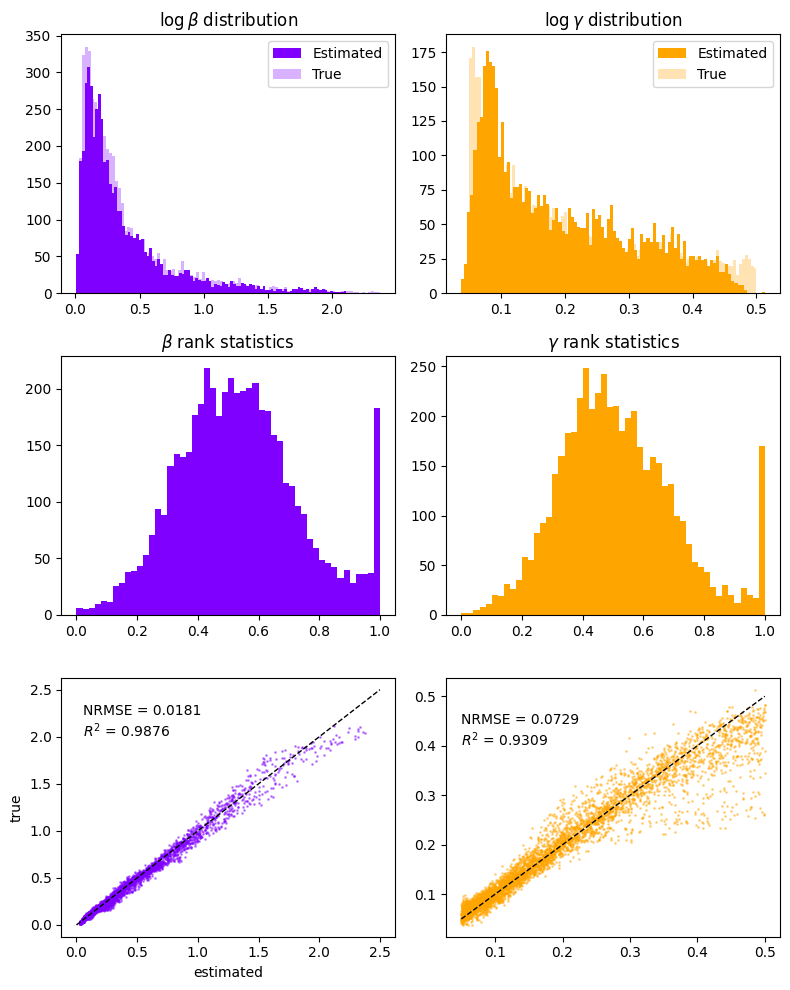

In [23]:
metrics(cnn_model, cnn_summary)

True: tensor([0.2682, 0.0783], device='cuda:0'), Mean: tensor([0.2647, 0.0799]), STD: tensor([0.0501, 0.0474])
True: tensor([0.9884, 0.1990], device='cuda:0'), Mean: tensor([0.8890, 0.2084]), STD: tensor([0.0622, 0.0369])


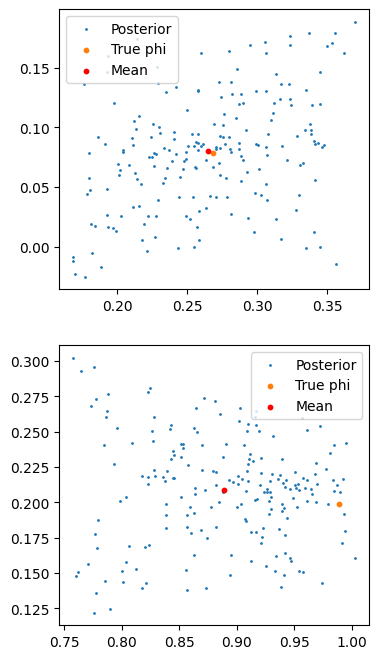

In [24]:
phi = sample_prior(2).to(device)
x = simulate(phi)
s = cnn_summary(x).to(device)

posterior = sample_posterior(cnn_model, s, n_steps=32, n_samples=200, plot=True).cpu()
mean = posterior.mean(dim=1)
std = (posterior - mean[:, None, :]).pow(2).mean(dim=1).pow(0.5)
for i in range(mean.shape[0]):
    print(f"True: {phi[i]}, Mean: {mean[i]}, STD: {std[i]}")

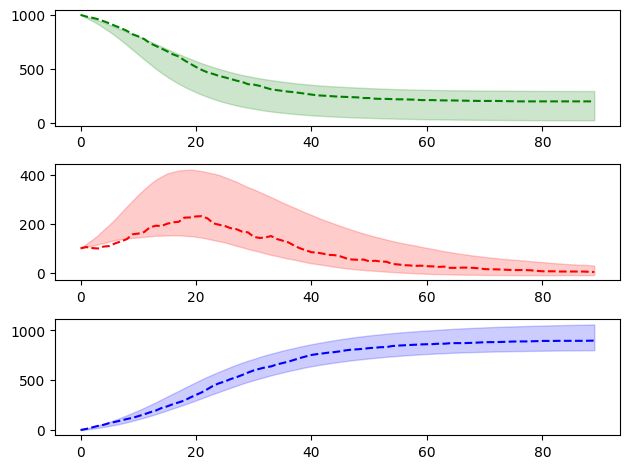

In [25]:
visualize_pred_simulation(cnn_model, cnn_summary)

По итогу можно сказать, что обучаемые саммари не дают большого преимущества и проблема скорее в потоковой части, а именно в том, что все саммари так или иначе слабо чувствительны к определенным областям априорного распределения и одной точке в латентном пространстве саммари может соответствовать несколько наборов параметров